- Generate a grid of FSPS spectra (in age and metallicity)
- perform PCA on this grid
- Perform gaussian processes regression on the coefficients 

In [124]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from astropy.cosmology import Planck15 as cosmo

import fsps

from sklearn.decomposition import PCA

In [ ]:
sp = fsps.StellarPopulation(zcontinuous=1, sfh=0, logzsol=0.0)

wl = np.array(sp.get_spectrum(tage=13, peraa=True)).T[:,0]

!! high metallicites blow up the SED, not sure why !!

In [228]:
ages = np.linspace(1e-1, cosmo.age(0).value, num=30)
metallicities = np.log(np.linspace(3e-3, 1.5e-2, num=30) / 0.0134)  # log(Z / Zsol)

In [229]:
spec = np.zeros((len(ages), len(metallicities), 5994))

for i, a in enumerate(ages):
    for j, Z in enumerate(metallicities):

        sp.params['logzsol'] = Z
        
        spec[i][j] = np.log10(sp.get_spectrum(tage=a, peraa=True)).T[:,1]
        

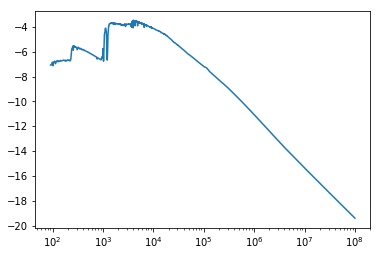

In [230]:
plt.semilogx(wl, spec[2,0])

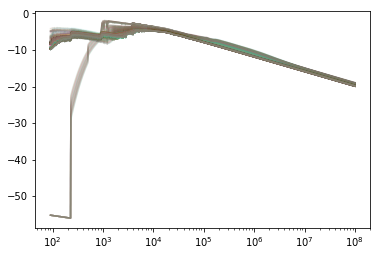

In [231]:
for s in spec.reshape((len(ages)*len(metallicities), 5994)):
    plt.semilogx(wl, s, alpha=0.1)


In [237]:
comps = 10
spectra_pca = PCA(n_components=comps)
spectra_pca.fit(spec.reshape((len(ages)*len(metallicities), 5994)))

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

/home/chris/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


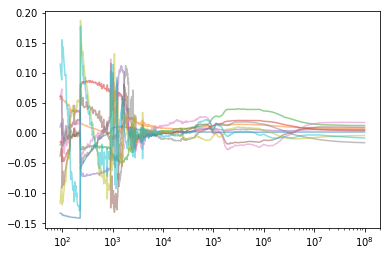

In [238]:
# plt.semilogx(wl, spectra_pca.mean_, label='mean', color='black')

for component in spectra_pca.components_:
    plt.semilogx(wl, component, alpha=0.5)

plt.legend()

In [239]:
coeffs = np.array(spectra_pca.transform(spec.reshape((len(ages)*len(metallicities), 5994))))
coeffs = coeffs.reshape((len(ages),len(metallicities),comps))
coeffs.shape

(30, 30, 10)

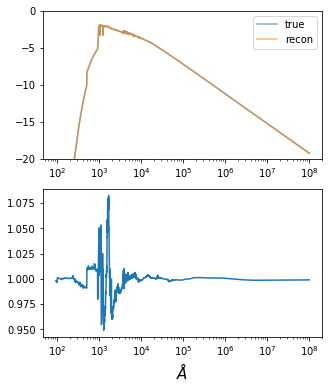

In [244]:
# reconstruct SFH
i = 0
j = 0

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(5,6))

ax1.semilogx(wl, spec[i,j], label='true', alpha=0.6)
ax1.semilogx(wl, spectra_pca.mean_ + np.dot(coeffs[i,j], spectra_pca.components_), label='recon', alpha=0.6)

ax1.legend()

ax1.set_ylim(-20, 0)

ax2.semilogx(wl, spec[i,j] / (spectra_pca.mean_ + np.dot(coeffs[i,j], spectra_pca.components_)))

ax2.set_xlabel('$\AA$', size=15)

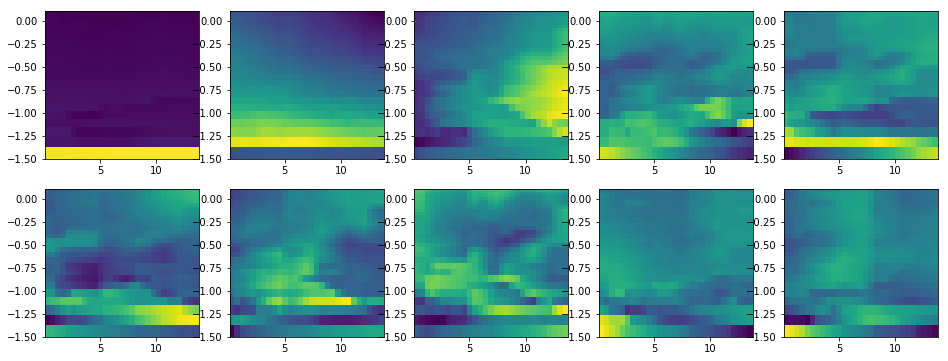

In [243]:
fig, axes = plt.subplots(2,5, figsize=(16,6))

axes = axes.flatten()

for i, ax in enumerate(axes):
    img = ax.pcolor(ages, metallicities, coeffs[:,:,i])
    